In [6]:
# BASELINE MODEL TRAINING
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [7]:
# Load cleaned dataset
df = pd.read_csv("/content/clean_email_dataset.csv")

In [9]:
print(df.isnull().sum())


text     0
label    1
dtype: int64


In [10]:
df = df.dropna()


In [11]:
# Recreate TF-IDF features
tfidf = TfidfVectorizer(max_features=10000)
X = tfidf.fit_transform(df['text'])  # No more NaN issues
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)


MultinomialNB()

In [12]:
# Initialize and train model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predictions
y_pred = nb_model.predict(X_test)

Classification Report:
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      2618
        spam       0.98      0.97      0.98      1467

    accuracy                           0.98      4085
   macro avg       0.98      0.98      0.98      4085
weighted avg       0.98      0.98      0.98      4085



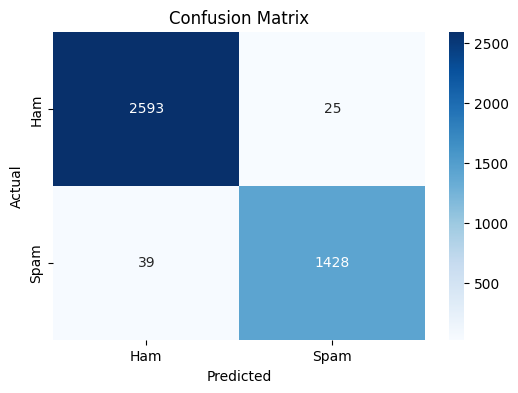

Accuracy: 0.98


In [13]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt="d",
            cmap="Blues",
            xticklabels=["Ham", "Spam"],
            yticklabels=["Ham", "Spam"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

In [14]:
# Get top 20 spam/ham indicators
feature_names = tfidf.get_feature_names_out()
ham_coefs = nb_model.feature_log_prob_[0]
spam_coefs = nb_model.feature_log_prob_[1]

top_ham_words = [feature_names[i] for i in ham_coefs.argsort()[-20:][::-1]]
top_spam_words = [feature_names[i] for i in spam_coefs.argsort()[-20:][::-1]]

print("Top Ham Indicators:", top_ham_words)
print("Top Spam Indicators:", top_spam_words)

Top Ham Indicators: ['enron', 'ect', 'subject', 'schedule', 'hou', 'vince', 'please', 'deal', 'date', 'hourahead', 'thanks', 'pm', 'hpl', 'would', 'com', 'cc', 'message', 'know', 'hour', 'gas']
Top Spam Indicators: ['subject', 'http', 'com', 'get', 'click', 'www', 'online', 'email', 'price', 'software', 'save', 'company', 'offer', 'order', 'free', 'money', 'want', 'best', 'remove', 'new']


In [ ]:
#EXPERIMENT WITH ADVANCED MODELS

# a) SVM
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Randomized Search
svm_model = RandomizedSearchCV(SVC(), svm_params, n_iter=10, cv=3, n_jobs=-1)
svm_model.fit(X_train, y_train)

In [ ]:
# b) Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

rf_model = RandomizedSearchCV(RandomForestClassifier(), rf_params, cv=3, n_jobs=-1)
rf_model.fit(X_train, y_train)

In [ ]:
# c) LSTM Deep Learning

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Convert TF-IDF to sequences (requires word-index mapping)
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df["text"])
X_seq = tokenizer.texts_to_sequences(df["text"])
X_pad = pad_sequences(X_seq, maxlen=200)

# Split new sequences
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_pad, df["label"], test_size=0.2)

# Model architecture
lstm_model = Sequential()
lstm_model.add(Embedding(10000, 128))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=5, batch_size=64)

In [ ]:
# 2) HYPERPARAMETER TUNING
# -> Grid Search for SVM

svm_grid = GridSearchCV(SVC(), svm_params, cv=5)
svm_grid.fit(X_train, y_train)
print("Best SVM Params:", svm_grid.best_params_)

In [ ]:
# -> Random Forest Optimization

rf_model.fit(X_train, y_train)
print("Feature Importances:", rf_model.best_estimator_.feature_importances_[:10])

In [ ]:
# 3) MODEL COMPARISON

models = {
    "Naive Bayes": nb_model,
    "SVM": svm_model.best_estimator_,
    "Random Forest": rf_model.best_estimator_
}

results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, pos_label="spam"),
        "Recall": recall_score(y_test, y_pred, pos_label="spam")
    })

results_df = pd.DataFrame(results)
print(results_df)

In [ ]:
# 4) SCALABLE TRAINING PIPELINE

from sklearn.pipeline import Pipeline

# End-to-end pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', SVC(C=10, kernel='linear'))  # Best model from comparison
])

# Save for deployment
import joblib
joblib.dump(pipeline, "spam_detection_pipeline.pkl")